<div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color: #2c3e50; line-height: 1.6; max-width: 900px; margin: auto; border: 1px solid #e1e4e8; border-radius: 15px; background-color: #ffffff; overflow: hidden; box-shadow: 0 10px 30px rgba(0,0,0,0.1);">

<div style="background: linear-gradient(135deg, #1e3c72 0%, #2a5298 100%); padding: 40px 30px; color: white; text-align: center;">
    <h1 style="margin: 0; font-size: 2.8em; font-weight: 800; letter-spacing: -1px;">🛒 Association Rule Mining</h1>
    <div style="width: 60px; height: 4px; background: #ffcc00; margin: 20px auto; border-radius: 2px;"></div>
    <p style="font-size: 1.1em; opacity: 0.9; max-width: 600px; margin: auto;">
        Strategic Basket Analysis to Drive Revenue and Optimize Customer Experience
    </p>
</div>

<div style="padding: 30px;">
    
<h3 style="color: #1e3c72; border-bottom: 2px solid #f0f2f5; padding-bottom: 10px; margin-top: 0;">🎯 Analysis Objectives</h3>
    <p>In this phase of the project, we leverage transaction data to decode consumer behavior with two primary goals:</p>
    
<div style="display: flex; gap: 20px; margin: 25px 0;">
        <div style="flex: 1; background: #fff9db; padding: 20px; border-radius: 10px; border-left: 5px solid #fab005;">
            <strong style="color: #862e1b; font-size: 1.1em;">💰 Profit Maximization</strong><br>
            <span style="font-size: 0.95em;">Identifying high-value product bundles and cross-selling opportunities to increase Average Order Value (AOV).</span>
        </div>
        <div style="flex: 1; background: #e7f5ff; padding: 20px; border-radius: 10px; border-left: 5px solid #228be6;">
            <strong style="color: #1864ab; font-size: 1.1em;">✨ User Experience</strong><br>
            <span style="font-size: 0.95em;">Streamlining the customer journey through intuitive recommendations and intelligent store layouts.</span>
        </div>
    </div>

<h3 style="color: #1e3c72; border-bottom: 2px solid #f0f2f5; padding-bottom: 10px;">🛠️ Methodological Framework</h3>
    <p>We will implement and compare four industry-standard models to extract frequent itemsets:</p>
    
    

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px; margin-top: 15px;">
        <div style="padding: 10px 15px; background: #f8f9fa; border-radius: 6px; font-family: monospace; border: 1px solid #e9ecef;">• Apriori Algorithm</div>
        <div style="padding: 10px 15px; background: #f8f9fa; border-radius: 6px; font-family: monospace; border: 1px solid #e9ecef;">• Eclat (Equivalence Class Transformation)</div>
        <div style="padding: 10px 15px; background: #f8f9fa; border-radius: 6px; font-family: monospace; border: 1px solid #e9ecef;">• FP-Growth (Frequent Pattern)</div>
        <div style="padding: 10px 15px; background: #f8f9fa; border-radius: 6px; font-family: monospace; border: 1px solid #e9ecef;">• UP-Tree (Utility Pattern)</div>
    </div>

<div style="margin-top: 35px; padding: 15px; background: #f1f3f5; border-radius: 8px; text-align: center; font-style: italic; color: #495057;">
        "Following each model, we will perform a deep-dive into the extracted rules to translate data patterns into actionable business insights."
    </div>

</div>
</div>

### Step 1 — Merge the tables

In [1]:
import pandas as pd

orders = pd.read_csv("..\data_raw\orders.csv")
order_products = pd.read_csv("..\data_raw\order_products__prior.csv")
products = pd.read_csv("..\data_raw\products.csv")

# Merge product names
df = order_products.merge(products, on="product_id")

df.head()


<>:3: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:4: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:5: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:3: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:4: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:5: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\i025423\AppData\Local\Temp\ipykernel_19400\2970818263.py:3: SyntaxWarning

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


### Step 2: Create baskets

We group products per order:

In [2]:
transactions = df.groupby('order_id')['product_name'].apply(list)
transactions.head()

order_id
2    [Organic Egg Whites, Michigan Organic Kale, Ga...
3    [Total 2% with Strawberry Lowfat Greek Straine...
4    [Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr...
5    [Bag of Organic Bananas, Just Crisp, Parmesan,...
6    [Cleanse, Dryer Sheets Geranium Scent, Clean D...
Name: product_name, dtype: object

### Step 3 — One-Hot Encoding (Basket Matrix)

Association algorithms need:

| order_id | Banana | Milk | Yogurt | Bread |
| -------- | ------ | ---- | ------ | ----- |
| 1        | 1      | 1    | 1      | 0     |
| 2        | 0      | 0    | 1      | 1     |
--------------------------------------------

We create it:


In [3]:
#import sys
#print(sys.executable)
#import sys
#!{sys.executable} -m pip install mlxtend

In [3]:
# because of the RAM error, I will delete rare products (90% of products are almost never bought)
product_counts = df['product_name'].value_counts()

popular_products = product_counts[product_counts > 2500].index

df_filtered = df[df['product_name'].isin(popular_products)]


In [4]:
# Limit commands :
# Instacart df contain the entire history of the cliens so we will consider only a sample
sample_orders = df_filtered['order_id'].drop_duplicates().sample(100000, random_state=42)

df_filtered = df_filtered[df_filtered['order_id'].isin(sample_orders)]

# Step 3: Recreate the trandactions DF
transactions = df_filtered.groupby('order_id')['product_name'].apply(list)


In [5]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

basket = pd.DataFrame(te_ary, columns=te.columns_)
basket.head()

,0% Fat Free Organic Milk,0% Greek Strained Yogurt,1 Liter,1 Ply Paper Towels,1% Low Fat Milk,1% Lowfat Milk,1% Milkfat Low Fat Buttermilk,100 Calorie Per Bag Popcorn,100% Apple Juice,100% Cranberry Juice,...,"Yogurt, Strained Low-Fat, Coconut",Yotoddler Organic Pear Spinach Mango Yogurt,Yukon Gold Potatoes 5lb Bag,ZBar Organic Chocolate Brownie Energy Snack,Zen Tea,Zero Calorie Cola,Zero Soda,of Hanover 100 Calorie Pretzels Mini,smartwater® Electrolyte Enhanced Water,with Crispy Almonds Cereal
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<div style="font-family: 'Segoe UI', Arial, sans-serif; color: #2c3e50; line-height: 1.6; border: 1px solid #e1e4e8; border-radius: 12px; background-color: #ffffff; overflow: hidden; box-shadow: 0 4px 15px rgba(0,0,0,0.05);">

<div style="background: #2c3e50; padding: 20px 25px; color: #ecf0f1;">
    <h3 style="margin: 0; font-size: 1.4em; display: flex; align-items: center;">
        <span style="margin-right: 12px;">📊</span> Association Rules: Key Metrics Explained
    </h3>
</div>

<div style="padding: 25px;">
    <p style="margin-bottom: 25px;">To interpret the results of our algorithms, we must understand the three pillars of <b>"Interestingness"</b> in Market Basket Analysis:</p>

<div style="display: flex; gap: 20px; margin-bottom: 20px; align-items: stretch;">
        <div style="background: #e1f5fe; color: #01579b; padding: 20px; border-radius: 8px; max-width: 100px; text-align: center; display: flex; flex-direction: column; justify-content: center; border: 1px solid #b3e5fc;">
            <strong style="font-size: 1.2em;">Support</strong>
            <small>Reliability</small>
        </div>
        <div style="flex: 1; padding: 10px;">
            <code style="color: #d63384; font-weight: bold;">support(A ∩ B)</code>
            <p style="margin: 5px 0;">The frequency of occurrences containing both <b>A</b> and <b>B</b>.</p>
            <div style="font-size: 0.85em; background: #f8f9fa; padding: 8px; border-radius: 4px; border-left: 3px solid #01579b;">
                <b>Example:</b> support = 0.02 → 2% of all baskets contain both products.
            </div>
        </div>
    </div>

<div style="display: flex; gap: 20px; margin-bottom: 20px; align-items: stretch;">
        <div style="background: #fff3e0; color: #e65100; padding: 20px; border-radius: 8px; max-width: 100px; text-align: center; display: flex; flex-direction: column; justify-content: center; border: 1px solid #ffe0b2;">
            <strong style="font-size: 1.2em;">Confidence</strong>
            <small>Probability</small>
        </div>
        <div style="flex: 1; padding: 10px;">
            <code style="color: #d63384; font-weight: bold;">P(B | A)</code>
            <p style="margin: 5px 0;">The likelihood that a customer buys <b>B</b> given that they already bought <b>A</b>.</p>
            <div style="font-size: 0.85em; background: #f8f9fa; padding: 8px; border-radius: 4px; border-left: 3px solid #e65100;">
                <b>Example:</b> Strawberries → Banana (0.68) → 68% of strawberry buyers also bought bananas.
            </div>
        </div>
    </div>

<div style="display: flex; gap: 20px; margin-bottom: 10px; align-items: stretch;">
        <div style="background: #e8f5e9; color: #2e7d32; padding: 20px; border-radius: 8px; max-width: 100px; text-align: center; display: flex; flex-direction: column; justify-content: center; border: 1px solid #c8e6c9;">
            <strong style="font-size: 1.2em;">Lift</strong>
            <small>Dependency</small>
        </div>
        <div style="flex: 1; padding: 10px;">
            <code style="color: #d63384; font-weight: bold;">Confidence / P(B)</code>
            <p style="margin: 5px 0;">The strength of the association between <b>A</b> and <b>B</b> compared to random chance.</p>
            
            
            
<div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 10px; margin-top: 10px; font-size: 0.8em; text-align: center;">
                <div style="padding: 5px; background: #eee; border-radius: 4px;"><b>= 1</b><br>Random Chance</div>
                <div style="padding: 5px; background: #d4edda; border-radius: 4px;"><b>> 1</b><br>Linked</div>
                <div style="padding: 5px; background: #c3e6cb; border-radius: 4px; border: 1px solid #28a745;"><b>> 2</b><br>Strong Relationship</div>
            </div>
        </div>
    </div>
</div>
</div>

In [6]:
from mlxtend.frequent_patterns import apriori, association_rules

# itemsets fréquents
frequent_itemsets = apriori(
    basket,
    min_support=0.01,
    use_colnames=True
)

# règles d'association
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.2
)

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,frozenset({Organic Baby Spinach}),frozenset({Bag of Organic Bananas}),0.07884,0.12338,0.01665,0.211187,1.711681,1.0,0.006923,1.111316,0.451365,0.089724,0.100166,0.173068
1,frozenset({Bag of Organic Bananas}),frozenset({Organic Baby Spinach}),0.12338,0.07884,0.01665,0.134949,1.711681,1.0,0.006923,1.064862,0.474298,0.089724,0.060911,0.173068
2,frozenset({Organic Hass Avocado}),frozenset({Bag of Organic Bananas}),0.07029,0.12338,0.02032,0.289088,2.343071,1.0,0.011648,1.233092,0.616547,0.117219,0.189031,0.226891
3,frozenset({Bag of Organic Bananas}),frozenset({Organic Hass Avocado}),0.12338,0.07029,0.02032,0.164694,2.343071,1.0,0.011648,1.113018,0.653886,0.117219,0.101542,0.226891
4,frozenset({Organic Raspberries}),frozenset({Bag of Organic Bananas}),0.04485,0.12338,0.01355,0.302118,2.448680,1.0,0.008016,1.256115,0.619397,0.087600,0.203895,0.205971


In [7]:
#rules.columns

In [8]:
strong_rules = rules[
    (rules['confidence'] > 0.01) &
    (rules['lift'] > 1.8) &
    (rules['support'] > 0.01)
].sort_values(by='lift', ascending=False)

strong_rules.head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
31,frozenset({Organic Raspberries}),frozenset({Organic Strawberries}),0.04485,0.08590,0.01182,0.263545,3.068046,1.0,0.007967,1.241217,0.705711,0.099386,0.194339,0.200574
30,frozenset({Organic Strawberries}),frozenset({Organic Raspberries}),0.08590,0.04485,0.01182,0.137602,3.068046,1.0,0.007967,1.107551,0.737403,0.099386,0.097107,0.200574
5,frozenset({Bag of Organic Bananas}),frozenset({Organic Raspberries}),0.12338,0.04485,0.01355,0.109823,2.448680,1.0,0.008016,1.072989,0.674884,0.087600,0.068024,0.205971
4,frozenset({Organic Raspberries}),frozenset({Bag of Organic Bananas}),0.04485,0.12338,0.01355,0.302118,2.448680,1.0,0.008016,1.256115,0.619397,0.087600,0.203895,0.205971
16,frozenset({Banana}),frozenset({Organic Fuji Apple}),0.15346,0.02814,0.01057,0.068878,2.447686,1.0,0.006252,1.043751,0.698669,0.061802,0.041917,0.222250
17,frozenset({Organic Fuji Apple}),frozenset({Banana}),0.02814,0.15346,0.01057,0.375622,2.447686,1.0,0.006252,1.355813,0.608576,0.061802,0.262435,0.222250
3,frozenset({Bag of Organic Bananas}),frozenset({Organic Hass Avocado}),0.12338,0.07029,0.02032,0.164694,2.343071,1.0,0.011648,1.113018,0.653886,0.117219,0.101542,0.226891
2,frozenset({Organic Hass Avocado}),frozenset({Bag of Organic Bananas}),0.07029,0.12338,0.02032,0.289088,2.343071,1.0,0.011648,1.233092,0.616547,0.117219,0.189031,0.226891
22,frozenset({Organic Avocado}),frozenset({Organic Baby Spinach}),0.05728,0.07884,0.01051,0.183485,2.327304,1.0,0.005994,1.128160,0.604971,0.083672,0.113601,0.158396
23,frozenset({Organic Baby Spinach}),frozenset({Organic Avocado}),0.07884,0.05728,0.01051,0.133308,2.327304,1.0,0.005994,1.087722,0.619130,0.083672,0.080647,0.158396


In [9]:
def recommend(product_name, rules, top_n=5):

    recs = rules[rules['antecedents'].apply(lambda x: product_name in x)]

    recs = recs.sort_values('lift', ascending=False)

    return recs[['consequents','confidence','lift']].head(top_n)

recommend('Organic Baby Spinach', rules)

,consequents,confidence,lift
23,frozenset({Organic Avocado}),0.133308,2.327304
24,frozenset({Organic Hass Avocado}),0.146880,2.089625
27,frozenset({Organic Strawberries}),0.158422,1.844262
0,frozenset({Bag of Organic Bananas}),0.211187,1.711681
15,frozenset({Banana}),0.207002,1.348896


<div style="font-family: 'Segoe UI', Roboto, sans-serif; color: #2d3748; line-height: 1.6; max-width:1200px; margin: auto; background-color: #fcfcfc; border: 1px solid #e2e8f0; border-radius: 16px; overflow: hidden; box-shadow: 0 10px 25px rgba(0,0,0,0.05);">

<div style="background: linear-gradient(135deg, #007bff 0%, #0056b3 100%); padding: 30px; color: white;">
    <h2 style="margin: 0; font-size: 1.8em; display: flex; align-items: center; gap: 12px;">
        <span>🛒</span> Recommendation Engine: Analysis
    </h2>
    <p style="margin: 10px 0 0 0; opacity: 0.9;">Target Product: <b>Organic Baby Spinach</b> ➜ What follows in the basket?</p>
</div>

<div style="padding: 30px;">
    
<div style="background: #ffffff; border: 1px solid #e2e8f0; border-radius: 12px; padding: 20px; margin-bottom: 40px; display: flex; gap: 20px; align-items: center; box-shadow: 0 2px 4px rgba(0,0,0,0.02);">
        <div style="flex: 1; max-width: 800px;">
            <h4 style="color: #007bff;">Intelligence Metrics</h4>
            <p style="font-size: 0.9em;">We filter candidates based on <b>Confidence</b> (Likelihood) and <b>Lift</b> (Behavioral Strength). A <span style="color: #2b6cb0; font-weight: bold;">Lift > 1.0</span> confirms the link isn't just a coincidence.</p>
        </div>
        <div style="border-left: 2px solid #edf2f7; padding-left: 20px;">
             <div style="font-size: 0.8em; margin-bottom: 5px;">🚀 <b>Lift Guide:</b></div>
             <span style="background: #edf2f7; padding: 2px 8px; border-radius: 4px; font-size: 0.75em;">1.0 = Coincidence</span>
             <span style="background: #c6f6d5; padding: 2px 8px; border-radius: 4px; font-size: 0.75em; color: #22543d;">1.5+ = Meaningful</span>
             <span style="background: #bee3f8; padding: 2px 8px; border-radius: 4px; font-size: 0.75em; color: #2a4365;">2.0+ = Strong Link</span>
        </div>
    </div>
</div>

<div style="margin-bottom: 50px; border: 1px solid #e2e8f0; border-radius: 12px; background: white; overflow: hidden;">
        <div style="display: flex; flex-wrap: wrap;">
            <div style="flex: 1; min-width: 300px; padding: 25px;">
                <h3 style="margin: 0 0 15px 0; color: #2d3748;">1. Organic Avocado</h3>
                <div style="display: flex; gap: 15px; margin-bottom: 20px;">
                    <div style="text-align: center; background: #f7fafc; padding: 10px; border-radius: 8px; flex: 1;">
                        <small style="display: block; color: #718096;">Confidence</small>
                        <strong style="font-size: 1.2em; color: #2b6cb0;">13.3%</strong>
                    </div>
                    <div style="text-align: center; background: #ebf8ff; padding: 10px; border-radius: 8px; flex: 1; border: 1px solid #bee3f8;">
                        <small style="display: block; color: #2b6cb0;">Lift Score</small>
                        <strong style="font-size: 1.2em; color: #2c5282;">2.32</strong>
                    </div>
                </div>
                <p style="font-size: 0.95em;"><b>Behavioral Signal:</b> This pairing screams intentional cooking. The user is likely building a <span style="background: #fff5f5; color: #c53030; padding: 1px 4px; border-radius: 3px;">Salad Bowl</span> or <span style="background: #fff5f5; color: #c53030; padding: 1px 4px; border-radius: 3px;">Healthy Smoothie</span>.</p>
                <div style="background: #f0fff4; padding: 12px; border-radius: 8px; border-left: 4px solid #38a169; font-size: 0.9em; margin-top: 15px;">
                    🎯 <b>Business Action:</b> Suggest Avocado as an "Essential Addition" for salad prep.
                </div>
            </div>
            <div style="flex: 1; min-width: 300px; background: #f7fafc; display: flex; align-items: center; justify-content: center; padding: 10px;">
                <img src="../images/organic-avocado.jpg" alt="Organic Avocado" style="max-width: 100%; border-radius: 8px; box-shadow: 0 4px 6px rgba(0,0,0,0.05);">
            </div>
        </div>
    </div>

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin-bottom: 40px;">
        <div style="border: 1px solid #e2e8f0; border-radius: 12px; padding: 20px; background: white;">
            <h4 style="margin: 0 0 10px 0;">2. Organic Hass Avocado</h4>
            <img src="../images/organic-hass-avocado.webp" alt="Hass Avocado" style="width: 100px; height: 100px; object-fit: cover; border-radius: 50%; border: 3px solid #ebf8ff;">
            <div style="font-size: 0.85em; margin-bottom: 10px;">
                <span style="color: #2b6cb0;">Confidence: 14.7%</span> | <span style="color: #38a169;">Lift: 2.08</span>
            </div>
            <div style="background: #fffaf0; padding: 10px; border-radius: 6px; font-size: 0.85em; border: 1px solid #feebc8;">
                💎 <b>Premium Segment:</b> Confirms preference for organic varieties and quality-conscious buying behavior.
            </div>
        </div>
        <div style="border: 1px solid #e2e8f0; border-radius: 12px; padding: 20px; background: white;">
            <h4 style="margin: 0 0 10px 0;">3. Organic Strawberries</h4>
            <img src="../images/strawberry-shortcake.png" alt="Organic Strawberries" style="width: 100px; height: 100px; object-fit: cover; border-radius: 50%; border: 3px solid #ebf8ff;">
            <div style="font-size: 0.85em; margin-bottom: 10px;">
                <span style="color: #2b6cb0;">Confidence: 15.8%</span> | <span style="color: #38a169;">Lift: 1.84</span>
            </div>
            <div style="background: #ebf8ff; padding: 10px; border-radius: 6px; font-size: 0.85em; border: 1px solid #bee3f8;">
                🥤 <b>Smoothie Bundle:</b> High potential for a "Smoothie Starter Kit" cross-promotion.
            </div>
        </div>
    </div>

<div style="background: #ffffff; border: 1px solid #e2e8f0; border-radius: 12px; padding: 25px;">
        <h4 style="margin: 0 0 20px 0; color: #2d3748; border-bottom: 2px solid #edf2f7; padding-bottom: 10px;">4 & 5. The Banana Benchmark</h4>
        
<div style="display: flex; gap: 20px; align-items: flex-start;">
            <div style="flex: 1;">
                <p style="font-size: 0.9em; margin-bottom: 15px;"><b>Organic Banana (Lift 1.71)</b> vs <b>Regular Banana (Lift 1.35)</b></p>
                <p style="font-size: 0.9em; color: #4a5568;">Banana acts as the <b>base ingredient</b> to soften the greens in smoothies. The higher lift for Organic suggests a consistent "Health-First" consumer profile.</p>
            </div>
            <div style="width: 200px; text-align: right;">
                <div style="margin-bottom: 10px; background: #e8f5e9; padding: 5px 10px; border-radius: 20px; display: inline-block; font-size: 0.75em; font-weight: bold; color: #2e7d32;">
                    Healthy-Leaning Segment
                </div>
            </div>
        </div>
        
<div style="display: flex; gap: 15px; margin-top: 20px;">
            <img src="../images/organic-banana.jpg" alt="Organic Banana" style="width: 100px; height: 100px; object-fit: cover; border-radius: 50%; border: 3px solid #ebf8ff;">
            <img src="../images/banana.webp" alt="Banana" style="width: 100px; height: 100px; object-fit: cover; border-radius: 50%; border: 3px solid #f7fafc;">
        </div>
    </div>

</div>

<div style="background: #f8fafc; padding: 15px; text-align: center; border-top: 1px solid #e2e8f0; font-size: 0.8em; color: #a0aec0; font-style: italic;">
    Market Basket Analysis | Instacart Dataset | Apriori Rules Extraction
</div>
</div>

In [ ]:
#!pip install networkx

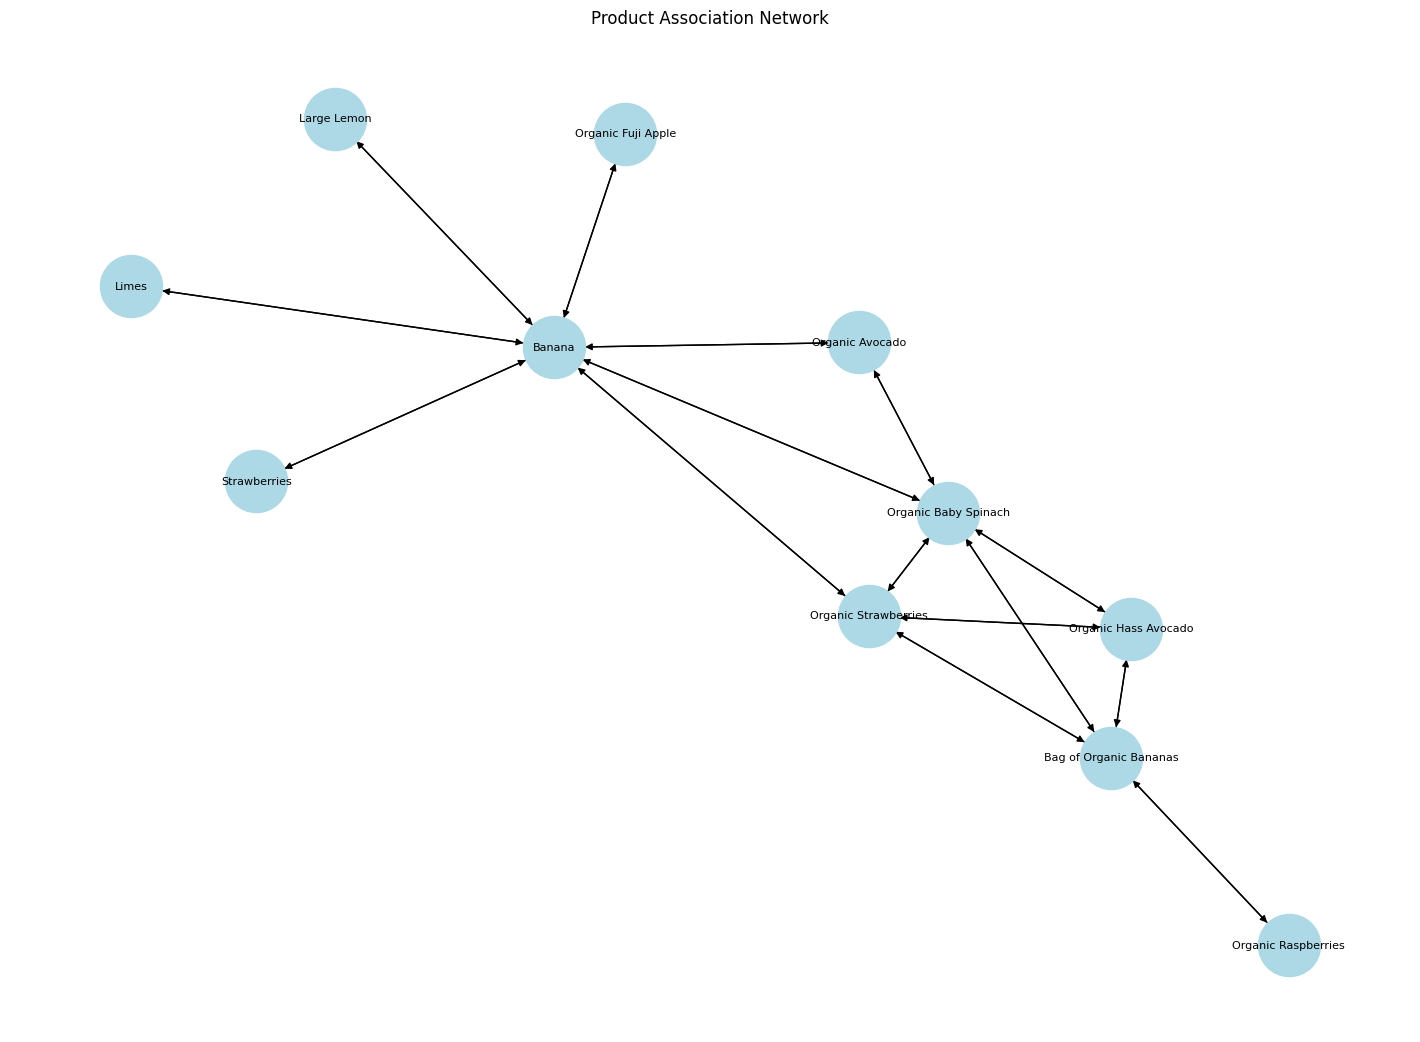

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for _, row in rules.head(30).iterrows():
    for a in row['antecedents']:
        for b in row['consequents']:
            G.add_edge(a, b, weight=row['lift'])

plt.figure(figsize=(14,10))
pos = nx.spring_layout(G, k=0.6)

nx.draw(G, pos,
        with_labels=True,
        node_size=2000,
        node_color="lightblue",
        font_size=8,
        arrows=True)

plt.title("Product Association Network")
plt.show()


<div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color: #2d3748; line-height: 1.7; max-width: 900px; margin: 20px auto; background: #ffffff; border-radius: 16px; border: 1px solid #e2e8f0; box-shadow: 0 10px 25px rgba(0,0,0,0.05); overflow: hidden;">

<div style="background: linear-gradient(135deg, #1a202c 0%, #2d3748 100%); padding: 30px; color: #63b3ed;">
    <h2 style="margin: 0; font-size: 1.6em; letter-spacing: 1px; color: white;">🕸️ Network Analysis: Results & Interpretations</h2>
    <p style="margin: 10px 0 0 0; opacity: 0.8; font-size: 0.95em; color: #a0aec0;">Decoding the "Supermarket Mental Map" through Association Rules</p>
</div>

<div style="padding: 30px;">

<div style="background: #f8fafc; border: 1px solid #e2e8f0; border-radius: 12px; padding: 20px; margin-bottom: 30px; display: flex; align-items: center; gap: 20px;">
        <div style="flex: 1;">
            <h4 style="margin: 0 0 10px 0; color: #2d3748;">1. How to read the Network?</h4>
            <ul style="margin: 0; padding-left: 20px; font-size: 0.9em; color: #4a5568;">
                <li><b>Nodes:</b> Represent individual products.</li>
                <li><b>Arrows (Edges):</b> Represent behavioral relationships (A → B).</li>
                <li><b>Proximity:</b> Closer products belong to the same <i>consumption context</i>.</li>
            </ul>
        </div>
        <div style="background: #ffffff; padding: 15px; border-radius: 8px; border: 1px solid #e2e8f0; text-align: center; max-width:500px;">
            <span style="font-size: 0.8em; color: #718096; display: block; margin-bottom: 5px;">Primary Goal:</span>
            <strong style="color: #3182ce;">Clustering Lifestyles, not Customers.</strong>
        </div>
    </div>

    

<div style="margin-bottom: 30px;">
        <div style="display: flex; align-items: center; gap: 10px; margin-bottom: 10px;">
            <span style="background: #3182ce; color: white; padding: 2px 8px; border-radius: 4px; font-weight: bold;">2</span>
            <h4 style="margin: 0; color: #2c5282;">The "Basket Anchor" Product</h4>
        </div>
        <div style="background: #ebf8ff; padding: 20px; border-radius: 12px; border: 1px solid #bee3f8;">
            <p style="margin-top: 0;">In our map, <b>Banana</b> acts as a "Traffic Generator."<br> It isn't just popular; it predicts the construction of an entire fruit basket.</p>
            <div style="display: flex; gap: 10px; font-family: monospace; font-size: 0.9em; color: #2a4365;">
                <span>🍌 → Avocado</span> | <span>🍌 → Fuji Apple</span> | <span>🍌 → Strawberries</span>
            </div>
            <p style="margin-bottom: 0; margin-top: 15px; font-size: 0.85em; font-style: italic;">💡 <b>Strategy:</b> Discounts on bananas pull all other connected items into the basket.</p>
        </div>
    </div>

<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px; margin-bottom: 30px;">
        
<div style="border: 1px solid #e2e8f0; border-radius: 12px; padding: 20px; background: #f0fff4;">
            <h4 style="margin: 0 0 15px 0; color: #276749;">3. Healthy Lifestyle Cluster</h4>
            <ul style="list-style: none; padding: 0; font-size: 0.85em; color: #2f855a;">
                <li style="margin-bottom: 5px;">✅ Organic Hass Avocado</li>
                <li style="margin-bottom: 5px;">✅ Organic Baby Spinach</li>
                <li style="margin-bottom: 5px;">✅ Organic Berries</li>
            </ul>
            <p style="font-size: 0.8em; margin-top: 10px; color: #22543d;"><b>Context:</b> Plant-based eating, diet/fitness, and smoothie bowls.</p>
        </div>

<div style="border: 1px solid #e2e8f0; border-radius: 12px; padding: 20px; background: #fff5f5;">
            <h4 style="margin: 0 0 15px 0; color: #c53030;">4. The "Avocado Chain"</h4>
            <div style="font-size: 0.85em; font-weight: bold; color: #9b2c2c;">
                Banana → Avocado → Spinach → Berries
            </div>
            <p style="font-size: 0.8em; margin-top: 10px; color: #822727;"><b>Discovery:</b> The algorithm reverse-engineered a <i>Smoothie Recipe</i> <br>from raw, anonymous transaction data.</p>
        </div>

</div>

<div style="background: #2d3748; color: white; border-radius: 12px; padding: 25px;">
        <h4 style="margin: 0 0 10px 0; color: #63b3ed;">5. Popularity vs. Dependency</h4>
        <p style="margin: 0; font-size: 0.95em; opacity: 0.9;">
            While <b>Banana</b> appears everywhere due to sheer volume, <b>Organic Baby Spinach</b> is a "Purpose-Driven" product. <br> It is less frequent, but its presence strongly predicts specific consumption intentions (High-Intent Shopping).
        </p>
        <div style="margin-top: 15px; display: flex; gap: 10px;">
            <span style="background: rgba(255,255,255,0.1); padding: 4px 10px; border-radius: 4px; font-size: 0.75em;">Personalize Homepage</span>
            <span style="background: rgba(255,255,255,0.1); padding: 4px 10px; border-radius: 4px; font-size: 0.75em;">Targeted Ads</span>
            <span style="background: rgba(255,255,255,0.1); padding: 4px 10px; border-radius: 4px; font-size: 0.75em;">Recipe Bundles</span>
        </div>
    </div>

</div>

<div style="background: #f8fafc; padding: 15px; text-align: center; border-top: 1px solid #e2e8f0; font-size: 0.8em; color: #a0aec0; font-style: italic;">
    Behavioral Segment Analysis | Instacart Market Basket Data
</div>
</div>

<div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color: #2d3748; line-height: 1.7; max-width: 1200px; margin: 20px auto; background: #ffffff; border-radius: 16px; border: 1px solid #e2e8f0; box-shadow: 0 10px 25px rgba(0,0,0,0.05); overflow: hidden;">

<div style="background: linear-gradient(135deg, #4c51bf 0%, #667eea 100%); padding: 30px; color: white;">
    <h2 style="margin: 0; font-size: 1.6em; letter-spacing: 1px;">⚡ Eclat Algorithm: Implementation</h2>
    <p style="margin: 10px 0 0 0; opacity: 0.9; font-size: 0.95em;">Equivalence Class Transformation for Vertical Itemset Mining</p>
</div>

<div style="padding: 30px;">

<div style="margin-bottom: 40px;">
        <div style="display: flex; align-items: center; gap: 12px; margin-bottom: 15px;">
            <span style="background: #4c51bf; color: white; width: 28px; height: 28px; display: flex; align-items: center; justify-content: center; border-radius: 50%; font-weight: bold; font-size: 0.9em;">1</span>
            <h4 style="margin: 0; color: #4c51bf; text-transform: uppercase; letter-spacing: 1px;">Environment Setup</h4>
        </div>
        <p style="margin-bottom: 15px;">First, we need to install the specialized <code>pyECLAT</code> library to handle vertical data structures efficiently.</p>
        <div style="background: #1a202c; padding: 15px; border-radius: 8px; border-left: 5px solid #48bb78; position: relative;">
            <code style="color: #cbd5e0; font-family: 'Cascadia Code', monospace;">pip install pyECLAT</code>
            <span style="position: absolute; right: 15px; top: 15px; color: #4a5568; font-size: 0.7em; text-transform: uppercase;">Terminal</span>
        </div>
    </div>

<div style="margin-bottom: 20px;">
        <div style="display: flex; align-items: center; gap: 12px; margin-bottom: 15px;">
            <span style="background: #4c51bf; color: white; width: 28px; height: 28px; display: flex; align-items: center; justify-content: center; border-radius: 50%; font-weight: bold; font-size: 0.9em;">2</span>
            <h4 style="margin: 0; color: #4c51bf; text-transform: uppercase; letter-spacing: 1px;">Data Transformation</h4>
        </div>
        <p>Eclat requires a specific input format where <b>each row represents a unique transaction</b>. We must transition from our raw relational structure to a clean transaction matrix.</p>
    </div>

<div style="display: flex; align-items: center; gap: 20px; background: #f8fafc; padding: 20px; border-radius: 12px; border: 1px solid #e2e8f0;">
        
<div style="flex: 1; text-align: center;">
            <span style="font-size: 0.75em; font-weight: bold; color: #718096; display: block; margin-bottom: 8px; text-transform: uppercase;">Current State</span>
            <img src="../images/transactions.png" alt="Transactions Dataframe" style="width: 100%; border-radius: 4px; border: 1px solid #cbd5e0; box-shadow: 0 4px 6px rgba(0,0,0,0.05);">
        </div>

<div style="color: #4c51bf; font-size: 2em; font-weight: bold;">➜</div>

<div style="flex: 1; text-align: center;">
            <span style="font-size: 0.75em; font-weight: bold; color: #718096; display: block; margin-bottom: 8px; text-transform: uppercase;">Eclat Input Ready</span>
            
<div style="margin-top: 10px; padding: 10px; background: #ebf8ff; border-radius: 6px; border: 1px dashed #4299e1; font-size: 0.8em; color: #2b6cb0;">
                <b>Transformation:</b> Converting relational IDs into a sparse transaction list.
            </div>
        </div>
</div>

</div>

<div style="background: #f8fafc; padding: 15px; text-align: center; border-top: 1px solid #e2e8f0; font-size: 0.8em; color: #a0aec0; font-style: italic;">
    Data Preprocessing Phase | Eclat Algorithm Workflow
</div>
</div>

<table style="border-collapse: collapse; margin: 25px 0; font-size: 0.9em; font-family: sans-serif;min-width: 400px; box-shadow: 0 0 20px rgba(0, 0, 0, 0.1); border-radius: 5px 5px 0 0; overflow: hidden;">
    <thead>
        <tr style = "background-color: #009879; color: #ffffff; text-align: left; font-weight: bold;">
            <th style = "padding: 12px 15px;">0</th>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Banana</td>
            <td>Yogurt</td>
            <td>Milk</td>
            <td>NaN</td>
        </tr>
        <tr>
            <td>Spinach</td>
            <td>Avocado</td>
            <td>NaN</td>
            <td>NaN</td>
        </tr>
        <tr>
            <td>Strawberry</td>
            <td>Banana</td>
            <td>Spinach</td>
            <td>Avocado</td>
        </tr>
    </tbody>
</table>

This is exactly what Eclat needs.
</p>

In [ ]:
transactions_list = transactions.tolist()
transactions_df = pd.DataFrame(transactions_list)
transactions_df.head()


,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,Cereal,French Onion Dip,Chicken Pot Pie,Presliced Everything Bagels,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tilapia Filet,Organic Lactose Free Whole Milk,XL Emerald White Seedless Grapes,Limes,Organic Avocado,No Salt Added Black Beans,Jalapeno Peppers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Baby Spinach Salad,Sliced Baby Bella Mushrooms,Unsweetened Almondmilk,Organic Hass Avocado,Organic Acorn Squash,Organic English Cucumber,Organic Strawberries,Organic Kiwi,Brussels Sprouts,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bag of Organic Bananas,Organic Vanilla Almond Milk,Large Pineapple Chunks,Raspberries,Crackers Cheddar Bunnies Snack Packs,"Juice Beverage, Cold Pressed, Kale Apple Ginge...",Toasted Coconut Chips Original Recipe,Yellow Onions,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Goodness Grapeness Organic Juice Drink,Organic Baby Spinach,Wild Berry Smoothie,Organic Jasmine Rice,Sea Salt Potato Chips,Organic Beef Hot Dogs,Buttermilk Biscuits,Organic Vanilla Almond Milk,Organic Yellow Mustard,Chopped Onions,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



<h3>2️⃣. Run Eclat</h3>

In [14]:
from pyECLAT import ECLAT

eclat = ECLAT(data=transactions_df)


In [15]:
# Now we mine frequent itemsets:
indices, support = eclat.fit(min_support=0.01,
                             min_combination=2,
                             max_combination=2)

Combination 2 by 2


3940it [14:58,  6.56it/s]

: 

: 

<div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; 
            max-width: 600px; 
            margin: 20px 0; 
            border: 1px solid #e1e4e8; 
            border-radius: 8px; 
            overflow: hidden; 
            box-shadow: 0 4px 6px rgba(0,0,0,0.05);">
    
<div style="background-color: #6096cc; color: white; padding: 15px 20px; font-size: 1.1em; font-weight: bold;">
        ⚙️ Association Rule Parameters
</div>

<div style="background-color: #ffffff; padding: 10px 0;">
        
<div style="display: flex; align-items: center; padding: 12px 20px; border-bottom: 1px solid #f0f2f5;">
<code style="background: #f1f3f5; color: #d63384; padding: 4px 8px; border-radius: 4px; font-weight: bold; min-width: 160px;">min_support=0.01</code>
<span style="margin-left: 15px; color: #4a5568;">➜ Appears in at least <b>1%</b> of baskets</span>
</div>

<div style="display: flex; align-items: center; padding: 12px 20px; border-bottom: 1px solid #f0f2f5;">
<code style="background: #f1f3f5; color: #d63384; padding: 4px 8px; border-radius: 4px; font-weight: bold; min-width: 160px;">min_combination=2</code>
<span style="margin-left: 15px; color: #4a5568;">➜ Analyzes <b>pairs</b> only</span>
</div>

<div style="display: flex; align-items: center; padding: 12px 20px;">
            <div style="display: flex; flex-direction: column;">
                <div style="display: flex; align-items: center;">
                    <code style="background: #f1f3f5; color: #d63384; padding: 4px 8px; border-radius: 4px; font-weight: bold; min-width: 160px;">max_combination=2</code>
                    <span style="margin-left: 15px; color: #4a5568;">➜ Avoids <b>memory explosion</b></span>
                </div>
                <div style="margin-left: 175px; margin-top: 5px; font-size: 0.85em; color: #e74c3c; font-style: italic; font-weight: bold;">
                    ⚠️ Highly Important for Performance
                </div>
            </div>
        </div>
</div>
</div>
<h3> 4️⃣ Explore the results </h3>

In [ ]:
support

{'Organic Hass Avocado & Organic Strawberries': 0.01343,
 'Organic Hass Avocado & Bag of Organic Bananas': 0.02032,
 'Organic Hass Avocado & Banana': 0.01033,
 'Organic Hass Avocado & Organic Baby Spinach': 0.01158,
 'Strawberries & Banana': 0.01348,
 'Organic Avocado & Banana': 0.01722,
 'Organic Avocado & Organic Baby Spinach': 0.01051,
 'Organic Raspberries & Organic Strawberries': 0.01182,
 'Organic Raspberries & Bag of Organic Bananas': 0.01355,
 'Organic Strawberries & Bag of Organic Bananas': 0.02017,
 'Organic Strawberries & Banana': 0.01836,
 'Organic Strawberries & Organic Baby Spinach': 0.01249,
 'Limes & Banana': 0.01034,
 'Bag of Organic Bananas & Organic Baby Spinach': 0.01665,
 'Large Lemon & Banana': 0.01255,
 'Banana & Organic Fuji Apple': 0.01057,
 'Banana & Organic Baby Spinach': 0.01632}

<h3>5️⃣. Convert Eclat output into rules (this is the missing step)</h3>
<p>
We now compute confidence manually.

Example:

$$Confidence(\text{Spinach} \rightarrow \text{Avocado}) = \frac{Support(\text{Spinach} \cap \text{Avocado})}{Support(\text{Spinach})}$$

$$Confidence = \frac{0.014}{0.06} = 0.2333... \approx 23.3\%$$

To construct this equation, we need to code it with python:

1. we compute individual supports:
</p>


In [ ]:
single_support = eclat.fit(min_support=0.01,
                           min_combination=1,
                           max_combination=1)[1]


Combination 1 by 1


108it [01:06,  1.62it/s]


2. We Calculate confidence:

In [ ]:
rules = []

for items, sup in support.items():
    products = items.split(" & ")

    # only keep pairs
    if len(products) == 2:
        A, B = products
        # A -> B
        if A in single_support:
            conf_AB = sup / single_support[A]
            rules.append((A, B, sup, conf_AB))

        # B -> A
        if B in single_support:
            conf_BA = sup / single_support[B]
            rules.append((B, A, sup, conf_BA))


rules_df = pd.DataFrame(rules, columns=['A','B','support','confidence'])
rules_df.sort_values('confidence', ascending=False).head(10)

,A,B,support,confidence
31,Organic Fuji Apple,Banana,0.01057,0.375622
16,Organic Raspberries,Bag of Organic Bananas,0.01355,0.302118
10,Organic Avocado,Banana,0.01722,0.300628
8,Strawberries,Banana,0.01348,0.292789
2,Organic Hass Avocado,Bag of Organic Bananas,0.02032,0.289088
14,Organic Raspberries,Organic Strawberries,0.01182,0.263545
28,Large Lemon,Banana,0.01255,0.259351
18,Organic Strawberries,Bag of Organic Bananas,0.02017,0.234808
24,Limes,Banana,0.01034,0.228609
20,Organic Strawberries,Banana,0.01836,0.213737


<div style="font-family: 'Segoe UI', Arial, sans-serif; color: #2c3e50; line-height: 1.6; max-width: 800px; margin: auto; padding: 20px; border: 1px solid #e1e4e8; border-radius: 15px; background-color: #ffffff;">

<div style="background: linear-gradient(135deg, #2c3e50 0%, #34495e 100%); color: white; padding: 25px; border-radius: 12px; margin-bottom: 30px; box-shadow: 0 4px 15px rgba(0,0,0,0.1);">
    <h2 style="margin: 0; font-size: 24px; letter-spacing: 1px;">📊 Results and Implications</h2>
    <p style="margin: 10px 0 0 0; opacity: 0.9; font-size: 0.95em;">Market Basket Analysis & Consumer Behavioral Study</p>
</div>

<div style="background-color: #f8f9fa; border-left: 5px solid #007bff; padding: 20px; margin-bottom: 30px; border-radius: 0 8px 8px 0;">
    <h4 style="margin-top: 0; color: #007bff;">Metric Key</h4>
    <p>Before diving into the results, here is how to read our association rules (<strong>A → B</strong>):</p>
    <ul style="list-style: none; padding-left: 0;">
        <li style="margin-bottom: 10px;">
            <span style="background: #007bff; color: white; padding: 2px 8px; border-radius: 4px; font-family: monospace;">confidence</span> 
            ➜ Probability of buying <b>B</b> when <b>A</b> is purchased.
        </li>
        <li style="margin-bottom: 10px;">
            <span style="background: #6c757d; color: white; padding: 2px 8px; border-radius: 4px; font-family: monospace;">support</span> 
            ➜ How often this pair appears across <b>ALL</b> transactions.
        </li>
    </ul>
    <div style="margin-top: 15px; padding: 10px; background: white; border-radius: 6px; border: 1px dashed #007bff;">
        <strong style="color: #d63384;">Example:</strong> Organic Fuji Apple → Banana (Confidence: <b>0.375</b>)<br>
        <small><i>Interpretation: 37.5% of Fuji Apple buyers also buy Bananas. (Retail Benchmark: >20% is strong).</i></small>
    </div>
</div>

<h3 style="border-bottom: 2px solid #eee; padding-bottom: 10px; color: #2c3e50;">💡 Strategic Insights</h3>
<p>We have grouped the data into <strong>3 core consumption patterns</strong>.</p>

<div style="margin-bottom: 40px; border: 1px solid #e1e4e8; border-radius: 12px; overflow: hidden;">
    <div style="background-color: #e8f5e9; padding: 15px 20px; border-bottom: 1px solid #e1e4e8;">
        <strong style="color: #2e7d32; font-size: 1.1em;">🟢 Pattern 1: The Fruit Basket (Base Signal)</strong>
    </div>
    <div style="padding: 20px;">
        <div style="display: flex; gap: 20px; flex-wrap: wrap;">
            <div style="flex: 1; min-width: 250px;">
                <span style="text-transform: uppercase; font-size: 0.75em; font-weight: bold; color: #95a5a6;">Rules Identified:</span>
                <ul style="list-style-type: '🚀 '; padding-left: 20px; color: #34495e; font-size: 0.9em;">
                    <li>Organic Fuji Apple → Banana</li>
                    <li>Strawberries → Banana</li>
                    <li>Large Lemon → Banana</li>
                    <li>Organic Raspberries → Bag of Organic Bananas</li>
                </ul>
            </div>
            <div style="flex: 1; min-width: 250px; background: #fffde7; padding: 15px; border-radius: 8px;">
                <strong style="display: block; margin-bottom: 5px;">🧠 Interpretation: "The Basket Builder"</strong>
                Banana is a <i>completion product</i>. Customers choose their primary fruit first, then add bananas because they are cheap, filling, and versatile.
            </div>
        </div>
        
<div style="margin-top: 20px;">
            <strong style="color: #d35400;">⚡ Business Actions:</strong>
            <div style="display: flex; gap: 10px; margin-top: 10px;">
                <div style="flex: 1; background: #fdf2f2; padding: 10px; border-radius: 6px; font-size: 0.85em; border: 1px solid #feb2b2;"><b>1. Recommend:</b> Suggest bananas instantly when berries are added to cart.</div>
                <div style="flex: 1; background: #fdf2f2; padding: 10px; border-radius: 6px; font-size: 0.85em; border: 1px solid #feb2b2;"><b>2. Pricing:</b> Don't discount bananas; use "Buy 2 Fruits, Get Banana Discount" to grow basket size.</div>
            </div>
        </div>
    </div>
</div>

<div style="margin-bottom: 40px; border: 1px solid #e1e4e8; border-radius: 12px; overflow: hidden;">
    <div style="background-color: #e3f2fd; padding: 15px 20px; border-bottom: 1px solid #e1e4e8;">
        <strong style="color: #1565c0; font-size: 1.1em;">🔵 Pattern 2: Smoothie / Healthy Eating Mission</strong>
    </div>
    <div style="padding: 20px;">
        <p>Our algorithm reverse-engineered a <b>recipe</b> from anonymous data. This is planned meal behavior.</p>
        <div style="background: #f1f8ff; padding: 15px; border-radius: 8px; border: 1px solid #c8e1ff; margin-bottom: 15px;">
            <span style="font-weight: bold; color: #0366d6;">🥤 The "Smoothie Kit" Opportunity:</span><br>
            Bundling <i>Raspberries + Avocado + Banana</i> increases basket value because these customers already intend to buy the set.
        </div>
        <ul style="list-style-type: '✅ '; padding-left: 20px; font-size: 0.9em;">
            <li>Organic Raspberries → Organic Strawberries</li>
            <li>Organic Hass Avocado → Bag of Organic Bananas</li>
        </ul>
    </div>
</div>

<div style="border: 1px solid #e1e4e8; border-radius: 12px; overflow: hidden; background: #fafafa;">
    <div style="background-color: #fff3e0; padding: 15px 20px; border-bottom: 1px solid #e1e4e8;">
        <strong style="color: #ef6c00; font-size: 1.1em;">🟠 Pattern 3: Citrus & Flavor Complementarity</strong>
    </div>
    <div style="padding: 20px;">
        <p>Customers buying <strong>Limes, Lemons and Banana</strong> Citrus fruits rarely eaten alone they are preparing specific recipes (drinks, salads, marinades).
        <div style="background: #fff3e0; padding: 15px; border-radius: 8px; border: 1px solid #c8e1ff; margin-bottom: 15px;">
        <span>Banana appears again because they’re shopping for multiple meal occasions at once.</span>
        </div>
        </p>
        <blockquote style="border-left: 4px solid #ff9800; margin: 0; padding-left: 15px; font-style: italic; color: #555;">
            "Customers don't shop per product. They shop per meal plan."
        </blockquote>
    </div>
</div>
</div>

<div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color: #2c3e50; line-height: 1.6;margin: 20px auto; border: 1px solid #e1e4e8; border-radius: 12px; overflow: hidden; box-shadow: 0 8px 24px rgba(0,0,0,0.1); max-width: 900px ;">

<div style="background: #1a202c; color: #63b3ed; padding: 20px 25px; display: flex; align-i
tems: center; justify-content: space-between;">
    <div style="font-size: 1.5em; font-weight: bold; letter-spacing: 1px;">
        ⚡ FP-Growth Algorithm
    </div>
    <div style="background: rgba(99, 179, 237, 0.2); padding: 4px 12px; border-radius: 20px; font-size: 0.8em; border: 1px solid #63b3ed;">
        Industry Standard
    </div>
</div>

<div style="padding: 25px; background: #ffffff;">
    <p style="margin-top: 0;">Our analysis pipeline has evolved through three stages of Association Rule Mining:</p>
    
<div style="display: flex; gap: 10px; margin-bottom: 25px;">
        <div style="flex: 1; background: #f7fafc; padding: 10px; border-radius: 6px; text-align: center; border-bottom: 3px solid #cbd5e0;">
            <small style="color: #718096; display: block;">Step 1</small>
            <strong>Apriori</strong>
        </div>
        <div style="flex: 1; background: #f7fafc; padding: 10px; border-radius: 6px; text-align: center; border-bottom: 3px solid #cbd5e0;">
            <small style="color: #718096; display: block;">Step 2</small>
            <strong>Eclat</strong>
        </div>
        <div style="flex: 1; background: #ebf8ff; padding: 10px; border-radius: 6px; text-align: center; border-bottom: 3px solid #4299e1;">
            <small style="color: #4299e1; display: block;">Step 3</small>
            <strong>FP-Growth</strong>
        </div>
    </div>

<div style="background: #fffaf0; border-left: 5px solid #ed8936; padding: 15px; margin-bottom: 25px; border-radius: 4px;">
        <strong>The "Industrial" Advantage:</strong><br>
        FP-Growth provides the same high-quality rules as Apriori but is optimized for massive datasets like <b>Instacart</b> without causing memory or computation "explosions."
    </div>

<h4 style="color: #2d3748; margin-bottom: 15px; display: flex; align-items: center;">
        <span style="margin-right: 10px;">🏆</span> Why Enterprises Prefer FP-Growth
    </h4>
    
    

<table style="width: 100%; border-collapse: collapse; margin-top: 10px;">
        <tr style="background: #f8fafc;">
            <th style="padding: 12px; text-align: left; border-bottom: 2px solid #e2e8f0; width: 30%;">Method</th>
            <th style="padding: 12px; text-align: left; border-bottom: 2px solid #e2e8f0;">Mechanism</th>
        </tr>
        <tr>
            <td style="padding: 12px; border-bottom: 1px solid #edf2f7; font-weight: bold; color: #e53e3e;">Apriori</td>
            <td style="padding: 12px; border-bottom: 1px solid #edf2f7; color: #4a5568;">Scans dataset <b>repeatedly</b> for every candidate itemset.</td>
        </tr>
        <tr>
            <td style="padding: 12px; border-bottom: 1px solid #edf2f7; font-weight: bold; color: #38a169;">FP-Growth</td>
            <td style="padding: 12px; border-bottom: 1px solid #edf2f7; color: #4a5568;">Scans only <b>twice</b> and compresses the data into a high-speed <b>FP-Tree</b> structure.</td>
        </tr>
    </table>

<div style="margin-top: 30px; text-align: center; padding: 15px; border-top: 1px solid #edf2f7;">
        <span style="font-style: italic; color: #718096; font-size: 0.9em;">
            Scaling analytics from thousands to millions of baskets.
        </span>
    </div>
</div>
</div>

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from pandas import DataFrame

te = TransactionEncoder()

te_ary = te.fit(transactions).transform(transactions, sparse=True)
type(te_ary)
# We see: scipy.sparse._csr.csr_matrix



basket = DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
basket.info()
# We see: Sparse[bool, False]


<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 2273 entries, 0% Fat Free Organic Milk to with Crispy Almonds Cereal
dtypes: Sparse[bool, False](2273)
memory usage: 3.4 MB


In [ ]:
# 2️⃣ Run FP-Growth

from mlxtend.frequent_patterns import fpgrowth
fp_itemsets = fpgrowth(
    basket,
    min_support=0.01,
    use_colnames=True
)

fp_itemsets.head()


,support,itemsets
0,0.05728,frozenset({Organic Avocado})
1,0.04523,frozenset({Limes})
2,0.01380,frozenset({Jalapeno Peppers})
3,0.08590,frozenset({Organic Strawberries})
4,0.07029,frozenset({Organic Hass Avocado})


In [ ]:
# 3️⃣ Generate association rules


from mlxtend.frequent_patterns import association_rules

fp_rules = association_rules(
    fp_itemsets,
    metric="lift",
    min_threshold=1.2
)

fp_rules.head()

fp_rules = association_rules(
    fp_itemsets,
    metric="lift",
    min_threshold=1.2
)

fp_rules.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,frozenset({Banana}),frozenset({Organic Avocado}),0.15346,0.05728,0.01722,0.112212,1.959002,1.0,0.008430,1.061875,0.578279,0.088983,0.058269,0.206420
1,frozenset({Organic Avocado}),frozenset({Banana}),0.05728,0.15346,0.01722,0.300628,1.959002,1.0,0.008430,1.210430,0.519280,0.088983,0.173847,0.206420
2,frozenset({Organic Avocado}),frozenset({Organic Baby Spinach}),0.05728,0.07884,0.01051,0.183485,2.327304,1.0,0.005994,1.128160,0.604971,0.083672,0.113601,0.158396
3,frozenset({Organic Baby Spinach}),frozenset({Organic Avocado}),0.07884,0.05728,0.01051,0.133308,2.327304,1.0,0.005994,1.087722,0.619130,0.083672,0.080647,0.158396
4,frozenset({Banana}),frozenset({Limes}),0.15346,0.04523,0.01034,0.067379,1.489700,1.0,0.003399,1.023749,0.388315,0.054898,0.023198,0.147994


In [ ]:
# 4️⃣ Filter strong rules (important)

strong_fp_rules = fp_rules[
    (fp_rules['confidence'] > 0.25) &
    (fp_rules['lift'] > 1.5)
].sort_values(by='lift', ascending=False)

strong_fp_rules.head(15)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
29,frozenset({Organic Raspberries}),frozenset({Organic Strawberries}),0.04485,0.08590,0.01182,0.263545,3.068046,1.0,0.007967,1.241217,0.705711,0.099386,0.194339,0.200574
26,frozenset({Organic Raspberries}),frozenset({Bag of Organic Bananas}),0.04485,0.12338,0.01355,0.302118,2.448680,1.0,0.008016,1.256115,0.619397,0.087600,0.203895,0.205971
31,frozenset({Organic Fuji Apple}),frozenset({Banana}),0.02814,0.15346,0.01057,0.375622,2.447686,1.0,0.006252,1.355813,0.608576,0.061802,0.262435,0.222250
14,frozenset({Organic Hass Avocado}),frozenset({Bag of Organic Bananas}),0.07029,0.12338,0.02032,0.289088,2.343071,1.0,0.011648,1.233092,0.616547,0.117219,0.189031,0.226891
1,frozenset({Organic Avocado}),frozenset({Banana}),0.05728,0.15346,0.01722,0.300628,1.959002,1.0,0.008430,1.210430,0.519280,0.088983,0.173847,0.206420
25,frozenset({Strawberries}),frozenset({Banana}),0.04604,0.15346,0.01348,0.292789,1.907917,1.0,0.006415,1.197012,0.498834,0.072465,0.164586,0.190315
22,frozenset({Large Lemon}),frozenset({Banana}),0.04839,0.15346,0.01255,0.259351,1.690024,1.0,0.005124,1.142971,0.429054,0.066297,0.125087,0.170566


<div style="font-family: 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; color: #2c3e50; line-height: 1.6; max-width: 1500px; margin: 20px auto; border: 1px solid #e1e4e8; border-radius: 12px; background-color: #fdfdfd; box-shadow: 0 10px 30px rgba(0,0,0,0.08); overflow: hidden;">

<div style="background: #2d3748; padding: 25px; color: #edf2f7; border-bottom: 4px solid #4a5568;">
    <h3 style="margin: 0; font-size: 1.4em; display: flex; align-items: center;">
        <span style="margin-right: 12px;">⏱️</span> Performance Benchmark: Apriori vs. FP-Growth
    </h3>
</div>

<div style="padding: 30px;">
    <p style="font-size: 1.05em; margin-bottom: 25px;">
        The most significant finding in our analysis was the disparity in <strong>computational efficiency</strong>. While both algorithms aim for the same mathematical destination, the "fuel" consumed varies drastically.
    </p>
    <div style="background: #ffffff; border: 1px solid #edf2f7; border-radius: 8px; padding: 20px; margin-bottom: 30px;">
        <h4 style="margin-top: 0; color: #4a5568; font-size: 0.9em; text-transform: uppercase; letter-spacing: 1px;">Verification of Result Integrity</h4>
    <div style="display: flex; gap: 20px; flex-wrap: wrap; margin-top: 15px;">
            <div style="flex: 1; min-width: 300px; text-align: center;">
                <p style="font-size: 0.8em; font-weight: bold; color: #718096; margin-bottom: 8px;">APRIORI OUTPUT</p>
                <img src="../images/appriori_rules.png" alt="Results rules of Apriori Algorithm" style="width: 90%; border-radius: 4px; border: 1px solid #eee; box-shadow: 0 2px 4px rgba(0,0,0,0.05);">
            </div>
            <div style="flex: 1; min-width: 300px; text-align: center;">
                <p style="font-size: 0.8em; font-weight: bold; color: #718096; margin-bottom: 8px;">FP-GROWTH OUTPUT</p>
                <img src="../images/fp_growth_rule.png" alt="Results rules of FP Growth Algorithm" style="width: 90%; border-radius: 4px; border: 1px solid #eee; box-shadow: 0 2px 4px rgba(0,0,0,0.05);">
            </div>
        </div>
        <p style="text-align: center; font-size: 0.85em; color: #a0aec0; margin-top: 15px;">
            <i>As shown above, the resulting rule-sets are mathematically identical.</i>
        </p>
    </div>
    <div style="margin-bottom: 30px;">
        <table style="width: 90%; border-collapse: collapse; font-size: 0.95em; border-radius: 8px; overflow: hidden; box-shadow: 0 4px 6px rgba(0,0,0,0.02);">
            <thead>
                <tr style="background-color: #f7fafc; border-bottom: 2px solid #e2e8f0;">
                    <th style="padding: 15px; text-align: left; color: #4a5568;">Algorithm</th>
                    <th style="padding: 15px; text-align: center; color: #4a5568;">Result Accuracy</th>
                    <th style="padding: 15px; text-align: right; color: #4a5568;">Execution Time</th>
                </tr>
            </thead>
            <tbody>
                <tr style="border-bottom: 1px solid #edf2f7;">
                    <td style="padding: 15px; font-weight: bold;">Apriori</td>
                    <td style="padding: 15px; text-align: center; color: #38a169;">✅ 100% Match</td>
                    <td style="padding: 15px; text-align: right; color: #e53e3e; font-weight: 600;">Slow (Minutes)</td>
                </tr>
                <tr style="background-color: #f0fff4;">
                    <td style="padding: 15px; font-weight: bold;">FP-Growth</td>
                    <td style="padding: 15px; text-align: center; color: #38a169;">✅ 100% Match</td>
                    <td style="padding: 15px; text-align: right; color: #38a169; font-weight: 700;">Fast (Seconds)</td>
                </tr>
            </tbody>
        </table>
    </div>
    <div style="background: #ebf8ff; width: 90%; border-radius: 8px; padding: 20px; display: flex; align-items: flex-start; gap: 15px;">
        <div style="font-size: 1.5em;">💡</div>
        <div>
            <strong style="color: #2b6cb0;">Core Conclusion:</strong>
            <p style="margin: 5px 0 0 0; color: #2c5282; font-size: 0.95em;">
                The advantage of <b>FP-Growth</b> is not the <i>quality</i> of results, but the <i>efficiency</i> of the process. In a real-world retail environment where datasets involve millions of transactions, FP-Growth is the only viable option for production-scale recommendation systems.
            </p>
        </div>
    </div>

</div>
</div>

<div style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; color: #2d3748; line-height: 1.7;margin: 20px auto; background: #ffffff; border-radius: 16px; border: 1px solid #e2e8f0; box-shadow: 0 10px 25px rgba(0,0,0,0.05); overflow: hidden;">

<div style="background: linear-gradient(135deg, #1a365d 0%, #2b6cb0 100%); padding: 30px; color: white;">
    <h2 style="margin: 0; font-size: 1.6em; letter-spacing: 0.5px;">📈 Results and Strategic Implications</h2>
    <p style="margin: 10px 0 0 0; opacity: 0.8; font-size: 0.95em;">
        Beyond Frequency: Leveraging <b>Dependency Strength</b> through FP-Growth
    </p>
</div>

<div style="padding: 30px;">
    
<div style="background: #ebf8ff; border-left: 5px solid #3182ce; padding: 20px; border-radius: 4px; margin-bottom: 35px;">
        <strong style="color: #2c5282;">Core Methodology:</strong>
        <p style="margin: 5px 0 0 0; font-size: 0.95em; color: #2a4365;">
            We prioritize rules based on <b>Interestingness</b>. A rule is only valuable if the presence of Product A significantly changes the probability of buying Product B (measured via <i>Lift, Leverage, and Conviction</i>).
        </p>
    </div>

<div style="margin-bottom: 40px; border: 1px solid #e2e8f0; border-radius: 12px; overflow: hidden;">
        <div style="background: #fff5f5; padding: 15px 20px; border-bottom: 1px solid #fed7d7; display: flex; justify-content: space-between; align-items: center;">
            <strong style="color: #c53030; font-size: 1.1em;">Rule 1: The "Berry Island" Effect</strong>
            <span style="background: #feb2b2; color: #9b2c2c; padding: 2px 10px; border-radius: 12px; font-size: 0.75em; font-weight: bold;">LIFT: 3.07</span>
        </div>
        <div style="padding: 20px;">
            <code style="display: block; background: #f7fafc; padding: 10px; border-radius: 6px; color: #d53f8c; margin-bottom: 15px; border: 1px solid #edf2f7;">
                Organic Raspberries → Organic Strawberries (Confidence: 0.263)
            </code>
            <p><strong>Interpretation:</strong> Customers are 3× more likely to buy strawberries if they have raspberries. They aren't just buying fruit; they are buying the <b>"Berry Consumption Type"</b> (smoothies, yogurt toppings, breakfast bowls).</p>
            
<div style="display: flex; gap: 10px; margin-top: 15px;">
                <div style="flex: 1; background: #f0fff4; padding: 12px; border-radius: 8px; border: 1px solid #c6f6d5; font-size: 0.85em;">
                    <b style="color: #2f855a;">🏪 Store Action:</b> Create a dedicated "Berry Island" shelf to capitalize on category affinity.
                </div>
                <div style="flex: 1; background: #f0fff4; padding: 12px; border-radius: 8px; border: 1px solid #c6f6d5; font-size: 0.85em;">
                    <b style="color: #2f855a;">💻 Web Action:</b> Implement "Intra-category" cross-sells inside the berry product pages.
                </div>
            </div>
        </div>
    </div>

<div style="margin-bottom: 40px; border: 1px solid #e2e8f0; border-radius: 12px; overflow: hidden;">
        <div style="background: #fffaf0; padding: 15px 20px; border-bottom: 1px solid #feebc8; display: flex; justify-content: space-between; align-items: center;">
            <strong style="color: #c05621; font-size: 1.1em;">Rule 2: Complementary Staples</strong>
            <span style="background: #fbd38d; color: #7b341e; padding: 2px 10px; border-radius: 12px; font-size: 0.75em; font-weight: bold;">LIFT: 2.44</span>
        </div>
        <div style="padding: 20px;">
            <code style="display: block; background: #f7fafc; padding: 10px; border-radius: 6px; color: #d53f8c; margin-bottom: 15px; border: 1px solid #edf2f7;">
                Organic Fuji Apple → Banana (Confidence: 0.375)
            </code>
            <p><strong>Behavioral Insight:</strong> Despite high base frequency, the lift of 2.44 proves apples <i>trigger</i> banana purchases. Bananas serve as the <b>"Basket Finalizer"</b> for kids' lunchboxes and weekly stock.</p>
            
<p style="background: #fffaf0; border: 1px dashed #f6ad55; padding: 10px; border-radius: 6px; font-size: 0.9em;">
                📍 <b>Placement Strategy:</b> Never merchandise bananas alone. Place them near apples and yogurt to act as a destination-adjacent completion product.
            </p>
        </div>
    </div>

<div style="margin-bottom: 40px; border: 1px solid #e2e8f0; border-radius: 12px; overflow: hidden;">
        <div style="background: #f0fff4; padding: 15px 20px; border-bottom: 1px solid #c6f6d5; display: flex; justify-content: space-between; align-items: center;">
            <strong style="color: #276749; font-size: 1.1em;">Rule 3: Mission-Based Linkage</strong>
            <span style="background: #9ae6b4; color: #22543d; padding: 2px 10px; border-radius: 12px; font-size: 0.75em; font-weight: bold;">LIFT: 2.34</span>
        </div>
        <div style="padding: 20px;">
            <code style="display: block; background: #f7fafc; padding: 10px; border-radius: 6px; color: #d53f8c; margin-bottom: 15px; border: 1px solid #edf2f7;">
                Organic Avocado → Banana | Bag of Organic Bananas
            </code>
            <p><strong>The "Smoothie" Context:</strong> These items are nutritionally unrelated but linked via <b>Usage Context</b> (Smoothies/Fitness Diets). Retailers should not recommend "another avocado," but rather the ingredients that <i>complete the mission</i>.</p>
            
<div style="margin-top: 10px; display: flex; gap: 5px;">
                <span style="background: #e2e8f0; padding: 4px 12px; border-radius: 15px; font-size: 0.8em;">+ Spinach</span>
                <span style="background: #e2e8f0; padding: 4px 12px; border-radius: 15px; font-size: 0.8em;">+ Protein Powder</span>
                <span style="background: #e2e8f0; padding: 4px 12px; border-radius: 15px; font-size: 0.8em;">+ Almond Milk</span>
            </div>
        </div>
    </div>

<div style="border: 1px solid #e2e8f0; border-radius: 12px; overflow: hidden; background: #f7fafc;">
        <div style="background: #edf2f7; padding: 15px 20px; border-bottom: 1px solid #e2e8f0;">
            <strong style="color: #4a5568; font-size: 1.1em;">Rule 4: Planned vs. Impulsive Shopping</strong>
        </div>
        <div style="padding: 20px;">
            <p>The link between <b>Citrus (Cooking)</b> and <b>Bananas (Snacking)</b> reveals that grocery trips are planned around weekly meal-cycles, not impulse buys. Use this to fuel <b>Recipe-Driven</b> recommendation engines.</p>
        </div>
    </div>

</div>
</div>

<h3> UP-Tree (Utility Pattern Tree) Algorithm </h3>
Using UP-Tree we will transform our analysis from customer behavior analysis to <strong>business profitability optimization</strong>.
Appriori -> frequent
Eclat -> Behavioral
FP-Growth -> scalable recommendation

But all of them share the same limitation: ❌ They assume <strong>all products have the same value</strong>.
But in reality this is wrong : Selling Banana (0.30 euro) is not equal to Olive Oil (4 euro). 

And as a retailer we don't want to recommend what is frequent, we want to recommand what increases <strong> revenue or margin. </strong>.

and that is exactly why we will use <strong>Utility Mining</strong> (UP-Tree)

<h4>1️⃣ What Utility Mining changes (very important concept)</h4>
Association rules uses: support = how often items appear
Utility mining uses: utility = quantity × profit (or value)

Example: 
| Product   | Times sold | Profit | Frequent? | Valuable? |
| --------- | ---------- | ------ | --------- | --------- |
| Banana    | 10000      | 0.1€   | ✔         | ❌         |
| Olive oil | 800        | 4€     | ❌         | ✔         |

So using this data if Appriori, Eclat and FP-Growth will recommand banana, UP-Tree will recommends olive oil. Which is exactly the difference between data science and business analytics. 

<h4>2️⃣ Problem: Instacart dataset has no price</h4>

Our dataset does not contain prices or they might have been removed. One solution that can be applicable here is simulate realistic prices, we assign a value to each product. 

<h4>3️⃣ Create a product price table</h4>

In [ ]:
aisles = pd.read_csv("../data_raw/aisles.csv")

products = products.merge(aisles, on="aisle_id")


In [ ]:
# We define approximate
price_map = {
    "fresh fruits": 1.5,
    "fresh vegetables": 1.8,
    "packaged vegetables fruits": 2.5,
    "yogurt": 2.2,
    "milk": 1.7,
    "soy lactosefree": 2.8,
    "bread": 2.0,
    "chips pretzels": 3.0,
    "energy granola bars": 3.5
}
# Assign prices
import numpy as np

def assign_price(aisle):
    base_price = price_map.get(aisle, np.random.uniform(2,6))
    return int(round(base_price * 100))   # convert to cents

products["price"] = products["aisle"].apply(assign_price)


# Then every product will have product

<h4>4️⃣ Attach price to transactions</h4>
Merge with order data:

In [ ]:
df_util = df_filtered.merge(products[["product_id","price"]], on="product_id")

<p>
Now each purchase has:
<ul>
<li>order_id</li>
<li>product</li>
<li>price</li>
</ul>
</p>

<h4>5️⃣ Compute transaction utility</h4>
<p>Utility mining needs each basket like:
order 1:
banana (1.5€)
strawberries (3€)
milk (2€)

So we create a dictionary per transaction.
</p>


In [ ]:
# All unique products that exist in the filtered dataset
unique_products = df_util['product_name'].unique()
# create ID mapping
product_to_id = {product: idx for idx, product in enumerate(unique_products)}

# reverse mapping (you will need it later to interpret patterns)
id_to_product = {idx: product for product, idx in product_to_id.items()}

print("Total products encoded:", len(product_to_id))

transactions_util = []

for order_id, group in df_util.groupby('order_id'):
    trans_dict = {}

    for _, row in group.iterrows():
        pid = product_to_id[row['product_name']]
        price = int(row['price'])
        trans_dict[pid] = price

    transactions_util.append(trans_dict)


Total products encoded: 2273


KeyboardInterrupt: 

<h4>6️⃣ Install a High-Utility Itemset Mining library</h4>
<p>
We will use PAMI (it implements <strong>UP-Tree</strong> style HUIM algorithms).

In VSCode terminal:

<code>pip install PAMI</code>
</p>
<h4>7️⃣ Convert to utility mining format</h4>

PAMI requires:

item1 item2 item3 : transactionUtility : u1 u2 u3

We create a file:

In [ ]:
with open("../data_clean/instacart_utility.txt", "w", encoding="utf-8") as f:
    for trans in transactions_util:
        items = list(trans.keys())
        utils = list(trans.values())
        TU = sum(utils)

        line = (
            "\t".join(str(i) for i in items) +      # <-- TAB HERE
            " : " + str(TU) +
            " : " +
            "\t".join(str(u) for u in utils) +      # <-- TAB HERE
            "\n"
        )

        f.write(line)


In [ ]:
# Before running UP-Tree, open the file and check the first 5 lines:
with open("../data_clean/instacart_utility.txt","r",encoding="utf-8") as f:
    for _ in range(5):
        print(f.readline())

# To check if it looks something like this:

# 15 93 204 : 845 : 150 275 420
# 44 82 : 430 : 180 250
# 101 205 16 : 960 : 320 410 230

# If there is any word on this data, means our data is wrong as UPGrowth requires only intergers

0	1	2	3 : 1573 : 222	507	348	496

4	5	6	7	8	9	10 : 1931 : 585	280	250	150	150	336	180

11	12	13	14	15	16	17	18	19 : 1770 : 250	250	280	150	180	180	150	150	180

20	21	22	23	24	25	26	27 : 2236 : 150	280	250	354	485	248	289	180

28	29	30	31	32	33	34	21	35	36	37	18	17	38	39	40	41	42 : 4877 : 290	250	220	206	300	299	287	280	314	250	300	150	150	150	150	271	463	547



In [ ]:
from PAMI.highUtilityPattern.basic import UPGrowth

model = UPGrowth.UPGrowth("../data_clean/instacart_utility.txt", minUtil=50)
model.mine()

patterns = model.getPatterns()

: 

: 

Now we obtain something like this:

(Avocado, Strawberries, Banana) → high utility
(Spinach, Banana, Berries) → high utility


THIS is your profit-driving combinations.
<h4>9️⃣ How to interpret UP-Tree results</h4>

Using the results of UP-Tree we can have the most important business insight to the project. 

<strong>Frequent ≠ Profitable</strong>

Example you will likely see:

Frequent:

<i>Banana + Strawberry</i>

High utility:

<i>Avocado + Berries + Spinach</i>


Why?

Because premium healthy baskets generate more revenue per order.

So:

Apriori optimizes clicks
UP-Tree optimizes money

<h4>🔟 Business Conclusions based on results</h4>